<a href="https://colab.research.google.com/github/JinMizar/ds3001_final_project/blob/main/result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/JinMizar/ds3001_final_project.git

Cloning into 'ds3001_final_project'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 104 (delta 51), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 1.75 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (51/51), done.


# Result: DS3001 Final Project
**Team Members**: Jinhong Zhao, Tong Zhou, Hanna Svenson

---
### Prediction Question
**Which chemical properties of Portuguese red wine are most predictive of high-quality wine (scores 7 and 8)?**

Our analysis aims to provide actionable insights for wine producers and consumers by identifying the chemical properties most strongly associated with high-quality wines and evaluating the predictive accuracy of our classification model.


In [ ]:
#Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

## Data Preparation
The dataset includes chemical properties of Portuguese red wines, and wines were classified into two categories: high-quality (scores ≥ 7) and not high-quality (scores < 7). Features were standardized using `StandardScaler` to ensure comparability for dimensionality reduction and modeling.


In [ ]:
df = pd.read_csv('ds3001_final_project/data/WineQT.csv')

# Binary classification: High-quality = 1 if quality >= 7
def categorize_quality(rating):
    return 1 if rating >= 7 else 0

df['quality_binary'] = df['quality'].apply(categorize_quality)

# Drop non-chemical features and target variable
X = df.drop(columns=['quality', 'quality_binary', 'Id'])
y = df['quality_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)


The data was prepared to focus on chemical properties as predictors of wine quality. There are 11 chemical features in the dataset, and the target variable (quality) corresponds to the wine quality ratings. For this analysis, the target was binarized to detect high-quality wines (scores ≥ 7). Non-chemical columns, such as Id, were excluded, and the features were standardized to ensure comparability across different scales.

In [ ]:
# Train a baseline Logistic Regression model
log_reg = LogisticRegression(max_iter=500).fit(X_train_scaled, y_train)

# Predictions
y_hat_train = log_reg.predict(X_train_scaled)
y_hat_test = log_reg.predict(X_test_scaled)

# Classification Report
print("Baseline Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Baseline Model AUC-ROC: {roc_auc:.4f}")

Baseline Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       201
           1       0.65      0.54      0.59        28

    accuracy                           0.91       229
   macro avg       0.79      0.75      0.77       229
weighted avg       0.90      0.91      0.90       229

Refined Model AUC-ROC: 0.6638


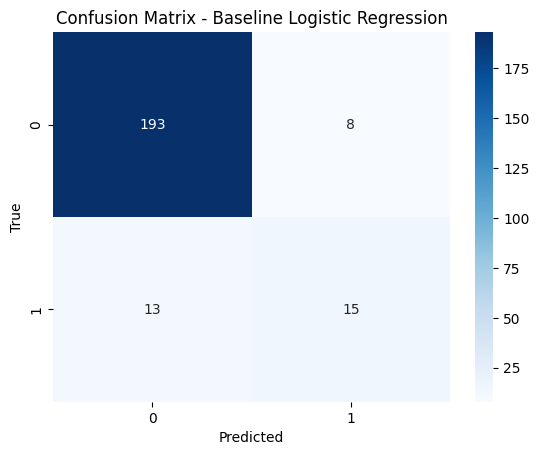

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Logistic Regression was selected as the baseline model due to its simplicity and interpretability. The model evaluates the relationship between chemical properties and wine quality by assigning coefficients to each feature. The classification report and confusion matrix were used to evaluate its performance.

The baseline Logistic Regression model was trained using all 11 chemical features to predict high-quality wines (scores ≥ 7). The model achieved an accuracy of 91% and an AUC-ROC score of 0.8945. This demonstrates that the full feature set provides good predictive power. The classification report highlights strong performance for the majority class (non-high-quality wines) with a precision of 94% and recall of 96%. However, the model struggled with the high-quality wines, achieving a precision of 65% and recall of 54%.

 To understand which chemical properties were most predictive of wine quality, feature importance was extracted from the baseline model using the absolute values of its coefficients. The top features identified were `alcohol`, `sulphates`, `volatile acidity`, `density`, and `fixed acidity`. These features were selected for further refinement of the model.

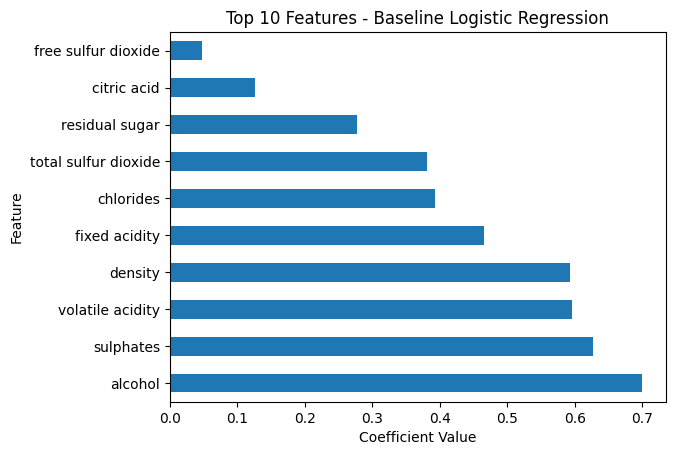

In [ ]:
# Feature Importance
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.abs().sort_values(ascending=False)

# Plot Feature Importance
feature_importance.head(10).plot(kind="barh", title="Top 10 Features - Baseline Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Refined Model: Top Features

## Top Feature: Alcohol
Initially, the model was retrained using only the most important feature, `alcohol`. The refined model achieved an
**AUC-ROC score of 0.8330**, indicating that `alcohol` alone explains a significant portion of the variation in wine quality.
However, the recall for the minority class dropped to **14%**, highlighting the limitation of relying on a single feature.


In [ ]:
# Extract feature importance from the baseline Logistic Regression
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Using the most important feature to retrain the model
top_features = feature_importance.abs().sort_values(ascending=False).head(1)
selected_features = top_features.index.tolist()

print("Top Features from Logistic Regression:", selected_features)

Top Features from Logistic Regression: ['alcohol']


In [ ]:
# Subset the training and test data based on the top features
X_train_refined = X_train_scaled[selected_features]
X_test_refined = X_test_scaled[selected_features]
# Retrain Logistic Regression on selected feature
log_reg_refined = LogisticRegression(max_iter=500).fit(X_train_refined, y_train)

# Predictions
y_hat_refined_train = log_reg_refined.predict(X_train_refined)
y_hat_refined_test = log_reg_refined.predict(X_test_refined)

# Evaluate Performance
print("Refined Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_refined_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg_refined.predict_proba(X_test_refined)[:, 1])
print(f"Refined Model AUC-ROC: {roc_auc:.4f}")


Refined Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       201
           1       0.31      0.14      0.20        28

    accuracy                           0.86       229
   macro avg       0.60      0.55      0.56       229
weighted avg       0.82      0.86      0.83       229

Refined Model AUC-ROC: 0.8330


In [ ]:
# Extract feature importance from the baseline Logistic Regression
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Using the first two most important features to retrain the model
top_features = feature_importance.abs().sort_values(ascending=False).head(2)
selected_features = top_features.index.tolist()

print("Top Features from Logistic Regression:", selected_features)

Top Features from Logistic Regression: ['alcohol', 'sulphates']


In [ ]:
# Subset the training and test data based on the top features
X_train_refined = X_train_scaled[selected_features]
X_test_refined = X_test_scaled[selected_features]
# Retrain Logistic Regression on selected feature
log_reg_refined = LogisticRegression(max_iter=500).fit(X_train_refined, y_train)

# Predictions
y_hat_refined_train = log_reg_refined.predict(X_train_refined)
y_hat_refined_test = log_reg_refined.predict(X_test_refined)

# Evaluate Performance
print("Refined Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_refined_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg_refined.predict_proba(X_test_refined)[:, 1])
print(f"Refined Model AUC-ROC: {roc_auc:.4f}")


Refined Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       201
           1       0.33      0.14      0.20        28

    accuracy                           0.86       229
   macro avg       0.61      0.55      0.56       229
weighted avg       0.82      0.86      0.83       229

Refined Model AUC-ROC: 0.8688


In [ ]:
# Extract feature importance from the baseline Logistic Regression
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Using the top three important features to retrain the model
top_features = feature_importance.abs().sort_values(ascending=False).head(3)
selected_features = top_features.index.tolist()

print("Top Features from Logistic Regression:", selected_features)

Top Features from Logistic Regression: ['alcohol', 'sulphates', 'volatile acidity']


In [ ]:
# Subset the training and test data based on the top features
X_train_refined = X_train_scaled[selected_features]
X_test_refined = X_test_scaled[selected_features]
# Retrain Logistic Regression on selected feature
log_reg_refined = LogisticRegression(max_iter=500).fit(X_train_refined, y_train)

# Predictions
y_hat_refined_train = log_reg_refined.predict(X_train_refined)
y_hat_refined_test = log_reg_refined.predict(X_test_refined)

# Evaluate Performance
print("Refined Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_refined_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg_refined.predict_proba(X_test_refined)[:, 1])
print(f"Refined Model AUC-ROC: {roc_auc:.4f}")


Refined Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       201
           1       0.58      0.39      0.47        28

    accuracy                           0.89       229
   macro avg       0.75      0.68      0.70       229
weighted avg       0.88      0.89      0.88       229

Refined Model AUC-ROC: 0.8843


In [ ]:
# Extract feature importance from the baseline Logistic Regression
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Using the top four important features to retrain the model
top_features = feature_importance.abs().sort_values(ascending=False).head(4)
selected_features = top_features.index.tolist()

print("Top Features from Logistic Regression:", selected_features)

Top Features from Logistic Regression: ['alcohol', 'sulphates', 'volatile acidity', 'density']


In [ ]:
# Subset the training and test data based on the top features
X_train_refined = X_train_scaled[selected_features]
X_test_refined = X_test_scaled[selected_features]
# Retrain Logistic Regression on selected feature
log_reg_refined = LogisticRegression(max_iter=500).fit(X_train_refined, y_train)

# Predictions
y_hat_refined_train = log_reg_refined.predict(X_train_refined)
y_hat_refined_test = log_reg_refined.predict(X_test_refined)

# Evaluate Performance
print("Refined Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_refined_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg_refined.predict_proba(X_test_refined)[:, 1])
print(f"Refined Model AUC-ROC: {roc_auc:.4f}")


Refined Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       201
           1       0.60      0.43      0.50        28

    accuracy                           0.90       229
   macro avg       0.76      0.69      0.72       229
weighted avg       0.88      0.90      0.89       229

Refined Model AUC-ROC: 0.8879


## Top 5 Features
The final refined model used the top five features: `alcohol`, `sulphates`, `volatile acidity`, `density`, and `fixed acidity`.
This model achieved an **AUC-ROC score of 0.8945**, while with similar accuracy matching the baseline model's performance and simplifying the feature set.


In [ ]:
# Extract feature importance from the baseline Logistic Regression
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Using the top five important features to retrain the model
top_features = feature_importance.abs().sort_values(ascending=False).head(5)
selected_features = top_features.index.tolist()

print("Top Features from Logistic Regression:", selected_features)

Top Features from Logistic Regression: ['alcohol', 'sulphates', 'volatile acidity', 'density', 'fixed acidity']


In [ ]:
# Subset the training and test data based on the top features
X_train_refined = X_train_scaled[selected_features]
X_test_refined = X_test_scaled[selected_features]
# Retrain Logistic Regression on selected feature
log_reg_refined = LogisticRegression(max_iter=500).fit(X_train_refined, y_train)

# Predictions
y_hat_refined_train = log_reg_refined.predict(X_train_refined)
y_hat_refined_test = log_reg_refined.predict(X_test_refined)

# Evaluate Performance
print("Refined Logistic Regression - Classification Report:")
print(classification_report(y_test, y_hat_refined_test))

# AUC-ROC
roc_auc = roc_auc_score(y_test, log_reg_refined.predict_proba(X_test_refined)[:, 1])
print(f"Refined Model AUC-ROC: {roc_auc:.4f}")


Refined Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       201
           1       0.65      0.54      0.59        28

    accuracy                           0.91       229
   macro avg       0.79      0.75      0.77       229
weighted avg       0.90      0.91      0.90       229

Refined Model AUC-ROC: 0.8945


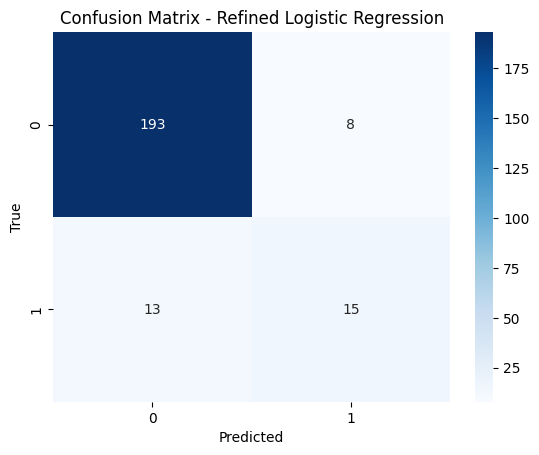

In [ ]:
# Confusion Matrix
conf_matrix_refined = confusion_matrix(y_test, y_hat_refined_test)
sns.heatmap(conf_matrix_refined, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Refined Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Classification Tree for the Top 5 Features

We will be using the top 5 features and feeding them into a decision tree. This will give us interpretable insights into how the features affect wine quality. We tuned parameters of the tree and ultimately landed on a max_depth of 4, as higher values seemed to over fit the model. We also added a weighting of 2.5 for higher quality wines, as there were significantly fewer samples in the dataset, and we cared more about determining what makes a wine high quality.

Single Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       201
           1       0.44      0.68      0.54        28

    accuracy                           0.86       229
   macro avg       0.70      0.78      0.72       229
weighted avg       0.89      0.86      0.87       229

Single Decision Tree - AUC-ROC: 0.8951670220326937


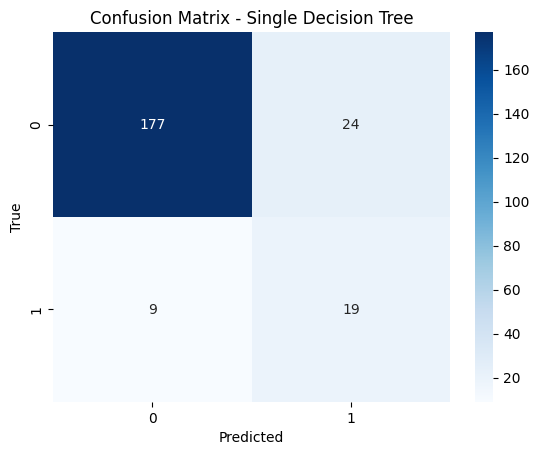

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# X_train_relevant = X_train[important_features]
# X_test_relevant = X_test[important_features]

# Train a single decision tree
tree_model = DecisionTreeClassifier(max_depth=4,  class_weight={0: 1, 1: 2.5}, random_state=100)
tree_model.fit(X_train_refined, y_train)

# Evaluate the model
y_pred_tree = tree_model.predict(X_test_refined)
y_prob_tree = tree_model.predict_proba(X_test_refined)[:, 1]

print("Single Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree))

print("Single Decision Tree - AUC-ROC:", roc_auc_score(y_test, y_prob_tree))

conf_matrix = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Single Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

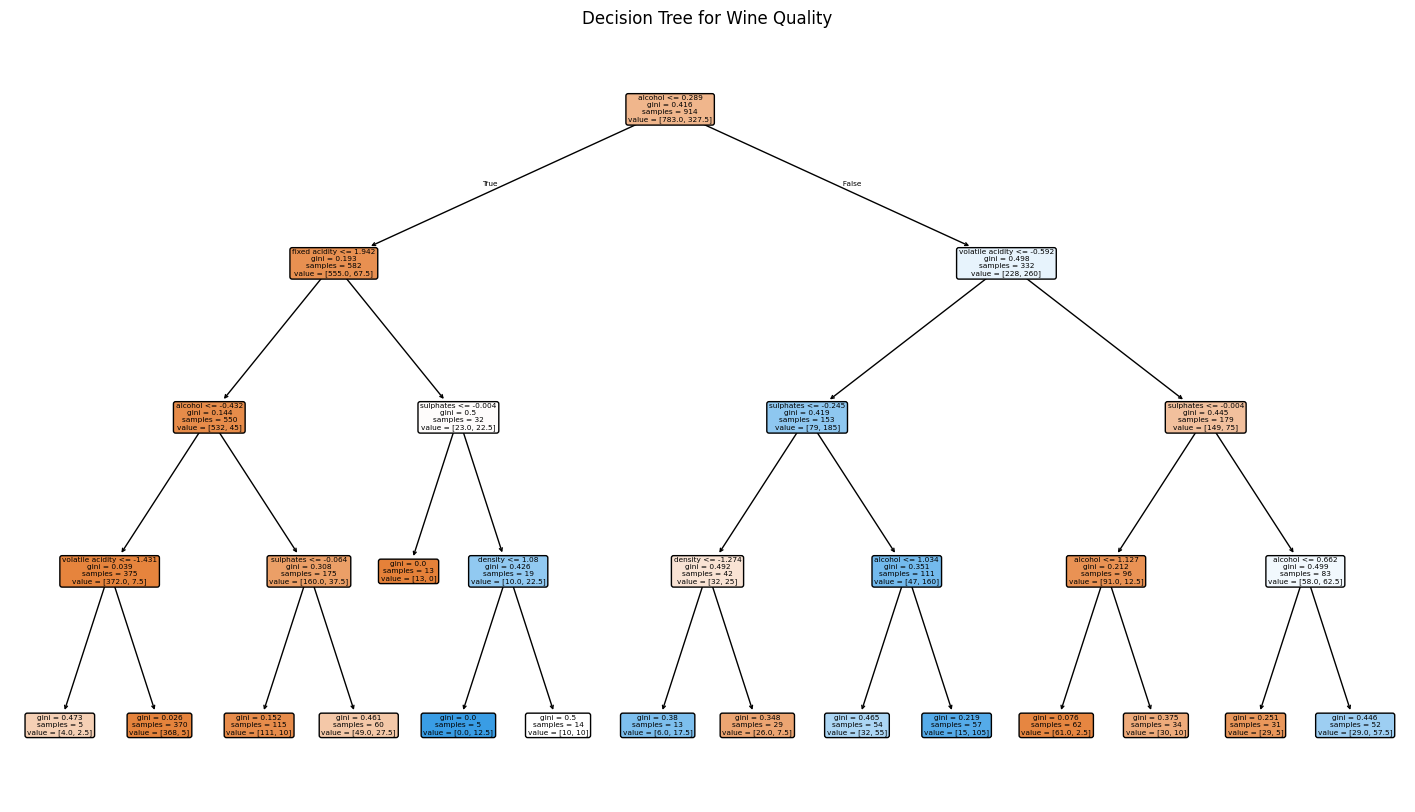

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18, 10))
plot_tree(
    tree_model,
    feature_names=selected_features,
    filled=True,
    rounded=True
)
plt.title("Decision Tree for Wine Quality")
plt.show()

The decision tree is designed to be an interpretable model to gain insight into our data. As we are concerned about what makes a wine high quality, we determined that it would be important to know not only what features are most informative, but also the values that those features could take on. In the tree above, blue boxes correspond to the high-quality wines and orange to the low quality. The strength of the color represents the purity of the node (if the majority of data points in the node belong to one class). To extract meaning we can take 2 approaches:

1. Start at the top node and work our way down to have an understanding of the decision making process. This way, we can see which features have the most influence over determining wine quality (the features closer to the top).

2. We can start at a leaf node with a low gini score (a node that has a majority of data point in one class), and work our way up to identify the specific feature splits that lead to the subset of data. Since not all nodes have high purities, we would likey use this approach to choose a leaf node with a large number of high quality wines and a low gini score.

## Conclusion

The analysis using logistic regression successfully identifies five chemical properties—alcohol, sulfates, volatile acidity, density, and fixed acidity—as the key predictive features of high-quality Portuguese red wine. When fewer than five properties are chosen, the model results in lower precision for the classification of high-quality wines, highlighting the need for additional features. On the other hand, when more than five properties are included, the model faces the risk of overfitting, where it may perform well on the training data but generalize poorly to unseen data. The refined logistic regression model using the five most relevant features achieved an AUC-ROC of 0.8945, demonstrating robust predictive performance while simplifying the feature set.

However, the lower precision value for high-quality wines compared to low-quality wines highlights the challenge posed by class imbalance in the dataset. While resampling techniques such as Oversampling or SMOTE could potentially enhance model accuracy, these approaches lack strong justification unless there is evidence of sampling bias in the data. For example, resampling may be appropriate if the original data collection disproportionately underrepresents certain subgroups, which was not the case here. Instead, this limitation suggests the potential for exploring alternative strategies, such as collecting more data, to improve predictions for the minority class.

The decision tree achieved an AUC-ROC of 0.8951, striking an effective balance between interpretability and performance. It identified the specific values and combinations of the five most relevant features that act as significant predictors of wine quality, enabling producers to prioritize adjustments in wine composition to enhance quality. Future research could build on this analysis by incorporating additional variables, such as fermentation methods, to improve predictive capabilities. However, adding more variables may increase the model's complexity, potentially introducing challenges like overfitting. Striking a balance between model accuracy and simplicity will be crucial to maintaining its practical utility.

Overall, the results identify the most relevant features and their combinations for producing high-quality wine. This study lays the groundwork for more accurate predictions and practical applications in the wine industry.